<a href="https://colab.research.google.com/github/Soutrik-Chakraborty/cardiac-modeling/blob/main/Cardiac_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os, glob, zipfile
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import nibabel as nib  # for .nii images
import numpy as np
from scipy.ndimage import zoom
from tkinter import Tk, filedialog

In [ ]:
from google.colab import files
uploaded = files.upload()  # Then select `cropped.zip` manually


Saving cropped.zip to cropped.zip


In [ ]:
import os
import zipfile

def unzip_local_zip():
    # Define the path to the uploaded ZIP file
    zip_path = "/content/cropped.zip"  # Ensure this is the correct path

    if not os.path.isfile(zip_path):
        raise FileNotFoundError(f"Zip file not found at: {zip_path}")

    # Define output directory
    output_dir = "/content/cropped_unzipped"
    os.makedirs(output_dir, exist_ok=True)

    # Extract the ZIP file
    try:
        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(output_dir)
        print(f"✅ Extracted dataset to: {output_dir}")
    except zipfile.BadZipFile:
        raise ValueError(f"❌ The file at {zip_path} is not a valid zip archive.")

    # List extracted files
    print("\n📂 Contents of extracted directory:")
    for root, dirs, files in os.walk(output_dir):
        level = root.replace(output_dir, '').count(os.sep)
        indent = ' ' * 4 * level
        print(f"{indent}{os.path.basename(root)}/")
        for f in files:
            print(f"{indent}    {f}")

    return output_dir


In [ ]:
output_dir = unzip_local_zip()

✅ Extracted dataset to: /content/cropped_unzipped

📂 Contents of extracted directory:
cropped_unzipped/
    cropped/
        pat45_cropped_seg_endpoints.nii.gz
        pat2_cropped_seg_endpoints.nii.gz
        pat39_cropped_seg_endpoints.nii.gz
        pat4_cropped_seg.nii.gz
        pat4_cropped.nii.gz
        pat21_cropped.nii.gz
        pat48_cropped_seg_endpoints.nii.gz
        pat42_cropped_seg_endpoints.nii.gz
        pat15_cropped_seg.nii.gz
        pat34_cropped_seg_endpoints.nii.gz
        pat15_cropped.nii.gz
        pat57_cropped_seg_endpoints.nii.gz
        pat9_cropped_seg.nii.gz
        pat39_cropped.nii.gz
        pat20_cropped_seg.nii.gz
        pat59_cropped_seg_endpoints.nii.gz
        pat48_cropped_seg.nii.gz
        pat3_cropped.nii.gz
        pat10_cropped.nii.gz
        pat0_cropped_seg_endpoints.nii.gz
        pat13_cropped_seg.nii.gz
        pat20_cropped_seg_endpoints.nii.gz
        pat38_cropped_seg_endpoints.nii.gz
        pat19_cropped_seg_endpoints.nii.gz
 

In [ ]:
import os
import nibabel as nib
import gzip
import shutil

def convert_nii_gz_to_nii(input_path, output_path=None):

    if not input_path.endswith(".nii.gz"):
        raise ValueError("Input file must be a .nii.gz file")

    # Set default output path
    if output_path is None:
        output_path = input_path[:-3]  # remove .gz extension

    # Load the image
    img = nib.load(input_path)

    # Save it in uncompressed .nii format
    nib.save(img, output_path)

    print(f"Converted {input_path} -> {output_path}")
    os.remove(input_path)
    print(f"Deleted original: {input_path}")
    return output_path



In [ ]:
folder = "/content/cropped_unzipped/cropped"
for file in os.listdir(folder):
    if file.endswith(".nii.gz"):
        full_path = os.path.join(folder, file)
        convert_nii_gz_to_nii(full_path)


FileNotFoundError: [Errno 2] No such file or directory: '/content/cropped_unzipped/cropped'

In [ ]:
#folder_path = "/content/cropped_unzipped/cropped"
def batch_convert_and_delete(folder_path):
    for filename in os.listdir(folder_path):
        if filename.endswith(".nii.gz"):
            full_path = os.path.join(folder_path, filename)
            convert_nii_gz_to_nii(full_path)

# Example usage
batch_convert_and_delete("/content/cropped_unzipped/cropped")
#batch_convert_and_delete("/content/cropped_unzipped/cropped")


Converted /content/cropped_unzipped/cropped/pat45_cropped_seg_endpoints.nii.gz -> /content/cropped_unzipped/cropped/pat45_cropped_seg_endpoints.nii
Deleted original: /content/cropped_unzipped/cropped/pat45_cropped_seg_endpoints.nii.gz
Converted /content/cropped_unzipped/cropped/pat2_cropped_seg_endpoints.nii.gz -> /content/cropped_unzipped/cropped/pat2_cropped_seg_endpoints.nii
Deleted original: /content/cropped_unzipped/cropped/pat2_cropped_seg_endpoints.nii.gz
Converted /content/cropped_unzipped/cropped/pat39_cropped_seg_endpoints.nii.gz -> /content/cropped_unzipped/cropped/pat39_cropped_seg_endpoints.nii
Deleted original: /content/cropped_unzipped/cropped/pat39_cropped_seg_endpoints.nii.gz
Converted /content/cropped_unzipped/cropped/pat4_cropped_seg.nii.gz -> /content/cropped_unzipped/cropped/pat4_cropped_seg.nii
Deleted original: /content/cropped_unzipped/cropped/pat4_cropped_seg.nii.gz
Converted /content/cropped_unzipped/cropped/pat4_cropped.nii.gz -> /content/cropped_unzipped/cro

In [ ]:
import glob
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import Dataset, DataLoader
from scipy.ndimage import zoom
import torch.nn as nn

class HVSMR3DDataset(Dataset):
    def __init__(self, root, split="train"):
        # Assuming a flat structure where images and masks are in the same folder
        # and can be paired by filename (e.g., patX_orig.nii and patX_orig_seg.nii)
        all_files = sorted(glob.glob(os.path.join(root, "*.nii")))

        images = [f for f in all_files if "_seg" not in f]
        masks  = [f for f in all_files if "_seg" in f]

        # Simple pairing based on removing "_seg" from mask filenames
        self.pairs = []
        image_dict = {os.path.basename(img).replace(".nii", ""): img for img in images}
        mask_dict = {os.path.basename(mask).replace("_seg.nii", ""): mask for mask in masks}

        # Assuming a simple split for demonstration based on a portion of the data
        # In a real scenario, you would have a more robust split (e.g., based on subject IDs)
        split_ratio = 0.8 # 80% for training, 20% for validation
        split_index = int(len(image_dict) * split_ratio)

        paired_keys = sorted(list(image_dict.keys() & mask_dict.keys()))

        if split == "train":
            paired_keys = paired_keys[:split_index]
        elif split == "val":
            paired_keys = paired_keys[split_index:]

        for key in paired_keys:
            self.pairs.append((image_dict[key], mask_dict[key]))

        if not self.pairs:
             raise ValueError(f"No image/mask pairs found for split '{split}' in {root}. Please check the file structure and naming convention.")


    def __len__(self): return len(self.pairs)
    def __getitem__(self, idx):
        img = nib.load(self.pairs[idx][0]).get_fdata().astype(np.float32)
        msk = nib.load(self.pairs[idx][1]).get_fdata().astype(np.int64)
        # Resize / normalize to (128,128,128)
        # Using order=1 for image interpolation and order=0 for mask (nearest neighbor)
        target_shape = (128, 128, 128)
        img = zoom(img, np.array(target_shape)/img.shape, order=1)
        msk = zoom(msk, np.array(target_shape)/msk.shape, order=0)

        # Ensure mask has the exact target shape after zooming
        if msk.shape != target_shape:
            # Create a new array of the target shape
            resized_msk = np.zeros(target_shape, dtype=msk.dtype)
            # Copy data from the zoomed mask, handling potential smaller/larger dimensions
            copy_shape = tuple(min(s1, s2) for s1, s2 in zip(msk.shape, target_shape))
            slices = tuple(slice(0, s) for s in copy_shape)
            resized_msk[slices] = msk[slices]
            msk = resized_msk

        img = (img - img.mean()) / img.std()
        return torch.unsqueeze(torch.from_numpy(img),0), torch.from_numpy(msk)

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=9):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(in_ch,16,3,padding=1), nn.ReLU(),
            nn.Conv3d(16,32,3,padding=1), nn.ReLU())
        self.pool = nn.MaxPool3d(2)
        self.dec = nn.Sequential(
            nn.ConvTranspose3d(32,16,2,stride=2), nn.ReLU(),
            nn.Conv3d(16,out_ch,1))
    def forward(self, x):
        x1 = self.enc(x)
        x2 = self.pool(x1)
        x3 = self.dec(x2)
        return x3

In [ ]:
def train_model(root):
    train_ds = HVSMR3DDataset(os.path.join(root, "cropped"), "train")
    val_ds   = HVSMR3DDataset(os.path.join(root, "cropped"), "val")
    train_loader = DataLoader(train_ds, batch_size=1, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=1)
    model = UNet3D()
    optim = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.CrossEntropyLoss()
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    for epoch in range(10):
        model.train()
        for img, msk in train_loader:
            img, msk = img.to(device), msk.to(device)
            pred = model(img)
            loss = loss_fn(pred, msk)
            optim.zero_grad(); loss.backward(); optim.step()

        # Validation
        model.eval()
        dice_sum, count = 0, 0
        with torch.no_grad():
            for img, msk in val_loader:
                img, msk = img.to(device), msk.to(device)
                pred = torch.argmax(model(img), dim=1)
                dice = (2*(pred==msk).float().sum()) / (pred.numel() + msk.numel())
                dice_sum += dice.item()
                count += 1
        print(f"Epoch {epoch}  Val Dice: {dice_sum/count:.4f}")

    torch.save(model.state_dict(), "hvsmr3d_unet.pth")

In [ ]:
if __name__ == "__main__":
  dataset_root = unzip_local_zip()
  train_model(dataset_root)

✅ Extracted dataset to: /content/cropped_unzipped

📂 Contents of extracted directory:
cropped_unzipped/
    cropped/
        pat45_cropped_seg_endpoints.nii.gz
        pat15_cropped.nii
        pat33_cropped_seg.nii
        pat0_cropped.nii
        pat2_cropped_seg_endpoints.nii.gz
        pat1_cropped_seg_endpoints.nii
        pat39_cropped_seg_endpoints.nii.gz
        pat4_cropped_seg.nii.gz
        pat4_cropped_seg.nii
        pat23_cropped_seg.nii
        pat4_cropped.nii.gz
        pat9_cropped_seg_endpoints.nii
        pat6_cropped_seg.nii
        pat21_cropped.nii.gz
        pat26_cropped_seg_endpoints.nii
        pat48_cropped_seg_endpoints.nii.gz
        pat10_cropped_seg_endpoints.nii
        pat42_cropped_seg_endpoints.nii.gz
        pat1_cropped_seg.nii
        pat15_cropped_seg.nii.gz
        pat8_cropped.nii
        pat58_cropped_seg_endpoints.nii
        pat35_cropped.nii
        pat34_cropped_seg_endpoints.nii.gz
        pat15_cropped.nii.gz
        pat57_cropped_seg_en

In [ ]:
pip install nibabel numpy scipy scikit-image matplotlib

In [ ]:
import os
import numpy as np
import nibabel as nib
import torch
from torch.utils.data import DataLoader
from scipy.ndimage import zoom
from skimage.metrics import adapted_rand_error
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
from scipy.spatial.distance import directed_hausdorff

In [ ]:
class HVSMR3DDatasetEval(torch.utils.data.Dataset):
    def __init__(self, root, split="val"):
        self.image_files = sorted(glob.glob(os.path.join(root, split, "images", "*.nii")))
        self.mask_files = sorted(glob.glob(os.path.join(root, split, "masks", "*.nii")))

    def __len__(self): return len(self.image_files)
    def __getitem__(self, idx):
        img = nib.load(self.image_files[idx]).get_fdata().astype(np.float32)
        msk = nib.load(self.mask_files[idx]).get_fdata().astype(np.int64)
        img = zoom(img, np.array([128/img.shape[0]]*3))
        msk = zoom(msk, np.array([128/msk.shape[0]]*3), order=0)
        img = (img - img.mean()) / img.std()
        return torch.unsqueeze(torch.from_numpy(img), 0), torch.from_numpy(msk), self.image_files[idx]

In [ ]:
class UNet3D(nn.Module):
    def __init__(self, in_ch=1, out_ch=9):
        super().__init__()
        self.enc = nn.Sequential(
            nn.Conv3d(in_ch,16,3,padding=1), nn.ReLU(),
            nn.Conv3d(16,32,3,padding=1), nn.ReLU())
        self.pool = nn.MaxPool3d(2)
        self.dec = nn.Sequential(
            nn.ConvTranspose3d(32,16,2,stride=2), nn.ReLU(),
            nn.Conv3d(16,out_ch,1))
    def forward(self, x):
        x1 = self.enc(x)
        x2 = self.pool(x1)
        x3 = self.dec(x2)
        return x3

In [ ]:
def dice_score(pred, true):
    intersection = np.sum((pred == true) & (true > 0))
    return 2. * intersection / (np.sum(pred > 0) + np.sum(true > 0) + 1e-5)

def jaccard_index(pred, true):
    return jaccard_score(true.flatten(), pred.flatten(), average='macro')

def hausdorff(pred, true):
    coords1 = np.argwhere(pred > 0)
    coords2 = np.argwhere(true > 0)
    return max(directed_hausdorff(coords1, coords2)[0],
               directed_hausdorff(coords2, coords1)[0])

In [ ]:
def show_3d_slice(pred, true, slice_id=64):
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.title("Ground Truth")
    plt.imshow(true[slice_id], cmap='gray')
    plt.subplot(1, 3, 2)
    plt.title("Prediction")
    plt.imshow(pred[slice_id], cmap='gray')
    plt.subplot(1, 3, 3)
    plt.title("Overlay")
    plt.imshow(true[slice_id], cmap='Reds', alpha=0.5)
    plt.imshow(pred[slice_id], cmap='Blues', alpha=0.5)
    plt.show()

In [ ]:
def evaluate_model(model_path, dataset_root):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = UNet3D()
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    # Use HVSMR3DDataset for evaluation with the validation split
    dataset = HVSMR3DDataset(os.path.join(dataset_root, "cropped"), split="val")
    loader = DataLoader(dataset, batch_size=1)


    dice_total, jacc_total, hd_total = 0, 0, 0
    count = 0

    # Create a directory to save predictions
    pred_output_dir = os.path.join(dataset_root, "predictions")
    os.makedirs(pred_output_dir, exist_ok=True)

    for img, msk in loader:
        img, msk = img.to(device), msk.to(device)
        with torch.no_grad():
            output = model(img)
            pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()
            true = msk.squeeze().cpu().numpy()

        # Save prediction as .nii
        # Get the original filename from the dataset (assuming the dataset returns it)
        # Note: HVSMR3DDataset currently does not return filename, we need to modify it
        # For now, let's use a simple counter for filename
        original_filename = f"pred_{count:03d}.nii" # Using a counter for filename
        out_path = os.path.join(pred_output_dir, original_filename)
        out_nifti = nib.Nifti1Image(pred.astype(np.uint8), affine=np.eye(4)) # Using identity affine for simplicity
        nib.save(out_nifti, out_path)
        print(f"Saved prediction to: {out_path}")


        # Evaluation
        dsc = dice_score(pred, true)
        jsc = jaccard_index(pred, true)
        hd  = hausdorff(pred, true)

        dice_total += dsc
        jacc_total += jsc
        hd_total += hd
        count += 1

        # Print metrics per sample (Optional)
        # print(f"[{count}] {original_filename}: Dice={dsc:.4f}  Jaccard={jsc:.4f}  HD={hd:.2f}")

        # Visualize middle slice (Optional)
        # show_3d_slice(pred, true)

    print("\n=== Overall Evaluation ===")
    print(f"Average Dice: {dice_total/count:.4f}")
    print(f"Average Jaccard: {jacc_total/count:.4f}")
    print(f"Average Hausdorff Distance: {hd_total/count:.2f}")

In [ ]:
if __name__ == "__main__":
    evaluate_model("hvsmr3d_unet.pth", "/content/cropped_unzipped")

Saved prediction to: /content/cropped_unzipped/predictions/pred_000.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_001.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_002.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_003.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_004.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_005.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_006.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_007.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_008.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_009.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_010.nii
Saved prediction to: /content/cropped_unzipped/predictions/pred_011.nii

=== Overall Evaluation ===
Average Dice: 0.1172
Average Jaccard: 0.1240
Average Hausdorff Distance: 44.80


**Instructions to fix the error:**

1.  **Upload the file:** Manually upload the `hvsmr2_0.zip` file to the `/content/` directory using the file browser in the left sidebar of Colab.
2.  **Verify the path:** If the file is already uploaded or located elsewhere, double-check the `zip_path` variable in the `unzip_local_zip` function to ensure it points to the correct location and filename of your zip file. Update it if necessary.

In [ ]:
# If you have uploaded the file to a different location or it has a different name,
# update the zip_path variable in the unzip_local_zip function accordingly.
# For example:
# def unzip_local_zip():
#     zip_path = "/path/to/your/zip/file.zip" # Update this line with the correct path
#     # ... rest of the function

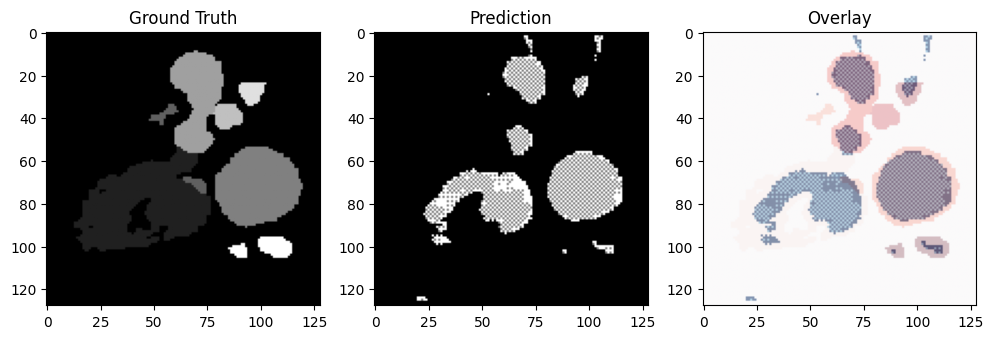

In [ ]:
# Load the validation dataset
dataset_root = "/content/cropped_unzipped"  # Assuming this is still the correct root
val_dataset = HVSMR3DDataset(os.path.join(dataset_root, "cropped"), split="val")

# Get a sample from the validation dataset (e.g., the first sample)
img, msk = val_dataset[0]

# Move the image to the same device as the model and add a batch dimension
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
img = img.unsqueeze(0).to(device)

# Load the trained model
model = UNet3D()
model.load_state_dict(torch.load("hvsmr3d_unet.pth", map_location=device))
model.to(device)
model.eval()

# Get the prediction
with torch.no_grad():
    output = model(img)
    pred = torch.argmax(output, dim=1).squeeze().cpu().numpy()

# Convert mask to numpy
true = msk.squeeze().cpu().numpy()

# Visualize a slice (e.g., slice 64)
show_3d_slice(pred, true, slice_id=64)

In [ ]:
pip install nibabel scikit-image trimesh vedo

In [ ]:
import os
import nibabel as nib
import numpy as np
from skimage import measure
import trimesh
from vedo import Plotter, Mesh

In [ ]:
def generate_3d_mesh_from_nii(nii_path, label=1, save_path=None, visualize=True):
    """
    Generate a 3D mesh from a binary/label NIfTI volume using Marching Cubes.

    Parameters:
        nii_path (str): Path to the .nii or .nii.gz segmentation file.
        label (int): Label value to extract (e.g., 1=left ventricle, etc.)
        save_path (str): Optional path to save .ply mesh.
        visualize (bool): Whether to show the mesh in 3D.
    Returns:
        mesh (trimesh.Trimesh): The extracted 3D mesh.
    """
    # Load NIfTI
    img = nib.load(nii_path)
    volume = img.get_fdata()

    # Extract binary mask of target label
    binary = (volume == label).astype(np.uint8)

    # Check if the binary volume contains the label before marching cubes
    if not np.any(binary):
        print(f"Warning: No voxels with label {label} found in {nii_path}. Cannot generate a mesh.")
        return None # Return None if no surface is found

    # Run marching cubes
    verts, faces, normals, values = measure.marching_cubes(binary, level=0)

    # Convert to mesh
    mesh = trimesh.Trimesh(vertices=verts, faces=faces)

    # Save as .ply or .stl if needed
    if save_path:
        mesh.export(save_path)
        print(f"Mesh saved to: {save_path}")

    # Optional 3D visualization using vedo
    if visualize:
        print("Visualizing mesh...")
        vedo_mesh = Mesh([verts, faces])
        plt = Plotter(title=f"3D Mesh - Label {label}")
        plt.show(vedo_mesh)

    return mesh

In [ ]:
# Path to your predicted mask (.nii) from the model
# Update the path to point to the saved prediction file
#pred_nifti = "/content/cropped_unzipped/predictions/pred_000.nii"
# Assuming the first prediction file

# Generate and visualize mesh for label 1 (e.g., left ventricle)
#generate_3d_mesh_from_nii(pred_nifti, label=0, save_path="heart_lv.ply")


import glob
import os

# Define the path to your prediction folder
pred_folder = "/content/cropped_unzipped/predictions"

# Get list of all .nii files in that folder
nii_files = glob.glob(os.path.join(pred_folder, "*.nii"))

# Loop through and generate mesh for each
for nii_path in nii_files:
    print(f"Processing: {nii_path}")

    # Extract filename for saving mesh
    filename = os.path.splitext(os.path.basename(nii_path))[0]
    save_mesh_path = f"/content/{filename}_label1.ply"

    # Run mesh generator for label=1 (e.g., left ventricle or main foreground)
    generate_3d_mesh_from_nii(nii_path, label=1, save_path=save_mesh_path)


Processing: /content/cropped_unzipped/predictions/pred_001.nii
Mesh saved to: /content/pred_001_label1.ply
Visualizing mesh...
Processing: /content/cropped_unzipped/predictions/pred_002.nii
Mesh saved to: /content/pred_002_label1.ply
Visualizing mesh...
Processing: /content/cropped_unzipped/predictions/pred_011.nii
Mesh saved to: /content/pred_011_label1.ply
Visualizing mesh...
Processing: /content/cropped_unzipped/predictions/pred_005.nii
Mesh saved to: /content/pred_005_label1.ply
Visualizing mesh...
Processing: /content/cropped_unzipped/predictions/pred_006.nii
Mesh saved to: /content/pred_006_label1.ply
Visualizing mesh...
Processing: /content/cropped_unzipped/predictions/pred_007.nii
Mesh saved to: /content/pred_007_label1.ply
Visualizing mesh...
Processing: /content/cropped_unzipped/predictions/pred_010.nii
Mesh saved to: /content/pred_010_label1.ply
Visualizing mesh...
Processing: /content/cropped_unzipped/predictions/pred_004.nii
Mesh saved to: /content/pred_004_label1.ply
Visu